# Principal Filter Analysis (PFA): Compression Basic Example for MobileNet on CIFAR-10

This notebook provides an example of how to apply [PFA](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA) to a model (MobileNet) using data from CIFAR-10 and obtain the recipes that PFA recommends to follow in order to re-architect the network and obtain a smaller model while trying to preserve accuracy.

## 1. Use DNIKit to run inference and collect responses from a model
In order to run PFA, it's necessary to run inference using some data and collect the responses from the layers to analyze and compress. See the docs for more information about how to [load a model](https://apple.github.io/dnikit/how_to/connect_model.html) into DNIKit.

In [1]:
import pandas as pd

from dnikit.base import pipeline, ImageFormat, ResponseInfo
from dnikit_tensorflow import TFModelExamples, TFDatasetExamples
from dnikit.processors import ImageResizer, Pooler

from dnikit.exceptions import enable_deprecation_warnings
enable_deprecation_warnings(error=True)  # treat DNIKit deprecation warnings as errors

### 1a. Download a model, MobileNet, and store it locally
This will be the model to analyze with PFA. [TFModelExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFModelExamples) are used to [load the model](https://apple.github.io/dnikit/how_to/connect_model.html), which loads the model from memory using [dnikit_tensorflow.load_tf_model_from_memory](https://apple.github.io/dnikit/api/dnikit/tensorflow.html#dnikit_tensorflow.load_tf_model_from_memory) under the hood.

In [2]:
# Load MobileNet
mobilenet = TFModelExamples.MobileNet()

2023-08-03 12:42:11.000611: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-03 12:42:11.000632: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-08-03 12:42:11.000635: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-08-03 12:42:11.000665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 12:42:11.000678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/private/tmp/dnikit-2.0.0/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 1.b Find input layers
The name of the input placeholder is needed to tell DNIKit where data needs to be fed. The following loop shows how all layers can be filtered to find the Input name.

The input name will be `input_1`, later this information will be used when inference is run.

In [3]:
possible_input_layers = [
    info.name
    for info in mobilenet.response_infos.values()
    if info.layer.kind is ResponseInfo.LayerKind.PLACEHOLDER
    and 'input' in info.name
]

print(possible_input_layers)

['input_1']


### 1.c Find Convolution layers
Similarly to the prior cell, here all layers are parsed in search of `Conv2D` layers. This is the set of layers that to analyze using PFA. If the list of names of the layers to analyze is already known, it can be passed directly to the loaded model (see step 1.f).

Notice that the output layer (whose name is `conv_preds`) is excluded, since its size is determined by the number of classes of this problem.

In [4]:
conv2d_responses = [
    info.name
    for info in mobilenet.response_infos.values()
    if info.layer.kind == ResponseInfo.LayerKind.CONV_2D
    and 'preds' not in info.name
]

for name in conv2d_responses:
    info = mobilenet.response_infos[name]
    print(f"{info.name} {info.shape}")

conv1 (Dimension(None), Dimension(112), Dimension(112), Dimension(32))
conv_dw_1 (Dimension(None), Dimension(112), Dimension(112), Dimension(32))
conv_pw_1 (Dimension(None), Dimension(112), Dimension(112), Dimension(64))
conv_pad_2 (Dimension(None), Dimension(113), Dimension(113), Dimension(64))
conv_dw_2 (Dimension(None), Dimension(56), Dimension(56), Dimension(64))
conv_pw_2 (Dimension(None), Dimension(56), Dimension(56), Dimension(128))
conv_dw_3 (Dimension(None), Dimension(56), Dimension(56), Dimension(128))
conv_pw_3 (Dimension(None), Dimension(56), Dimension(56), Dimension(128))
conv_pad_4 (Dimension(None), Dimension(57), Dimension(57), Dimension(128))
conv_dw_4 (Dimension(None), Dimension(28), Dimension(28), Dimension(128))
conv_pw_4 (Dimension(None), Dimension(28), Dimension(28), Dimension(256))
conv_dw_5 (Dimension(None), Dimension(28), Dimension(28), Dimension(256))
conv_pw_5 (Dimension(None), Dimension(28), Dimension(28), Dimension(256))
conv_pad_6 (Dimension(None), Dimensio

### 1.d Create a DNI Dataset wrapping CIFAR-10
Download CIFAR-10 data and only use 2000 images for the example, so inference is faster.

In order to be able to use CIFAR-10 in DNIKit, it's necessary to wrap the data into a [Producer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer) (if these were normal images, [ImageProducer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.ImageProducer) could be used with an input path).

Moreover, MobileNet accepts images of size `224x224`, so the CIFAR-10 images need to be pre-processed by resizing them from `32x32` to `224x224`. DNIKit provides a set of processors in the module [dnikit.processors](https://apple.github.io/dnikit/api/dnikit/processors.html). [ImageResizer](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.ImageResizer) is used and passed into a new [pipeline](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.pipeline) that applies such pre-processing on top of CIFAR-10.

**Note:** [TFDatasetExamples](https://apple.github.io/dnikit/api/dnikit_tensorflow/index.html#dnikit_tensorflow.TFDatasetExamples) are used here to load the data. To learn how to write a custom Producer that conforms to the [Producer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer) protocol, see [load data](https://apple.github.io/dnikit/how_to/connect_data.html) in the documentation.

In [5]:
# Load CIFAR10 from DNIKit's TF examples
cifar10_dataset = TFDatasetExamples.CIFAR10(max_samples=2000)
cifar10_dataset.shuffle()

# Here, use the standard MobileNet preprocessor,
# which was loaded into the "preprocessor" property when MobileNet was loaded:
mobilenet_preprocessor = mobilenet.preprocessing
assert mobilenet_preprocessor is not None

# Next, define an ImageResizer to 224x224.
resizer = ImageResizer(pixel_format=ImageFormat.HWC, size=(224, 224))

# Wrap the dataset that was just created with preprocessors,
# so DataBatches are pre-processed accordingly every time they are requested.
dataset = pipeline(cifar10_dataset, mobilenet_preprocessor, resizer)

### 1.f Run inference
Now run the data generated by the [pipeline](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.pipeline) and collect statistics regarding the activation of the units in the layers to analyze.

Here is where it's important to know how to map the data field `"images"` from the `Batch` to the input of the network `"input_1"`. This mapping is done by the [FieldRenamer](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.FieldRenamer). This feeds into the `dnikit_model` defined earlier to perform inference.

<img src="../assets/Inference.png" width="400">

PFA expects data to be of the form (`number_of_samples` x `number_of_units`) for each layer. This means that the response obtained after inference needs to be post-processed. The typical post-processing operation used is max-pooling. This is the task performed using a DNIKit [Processor](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.Processor), specifically, a [Pooler](https://apple.github.io/dnikit/api/dnikit/processors.html#dnikit.processors.Pooler).

<img src="../assets/Pooling.png" width="400">

The inference and pooling steps are repeated for all input data and the pooled responses are collected.

Note: although this section is titled "run inference", this actually defines *how* to run inference.  Until
the data is pulled through the pipeline (later when PFA introspection is run). Inference is not actually *run* here.

In [6]:
from dnikit.processors import Pooler, FieldRenamer

producer = pipeline(
    # the resized images
    dataset,

    # the loaded tensorflow model -- tell the model which responses to collect (computed earlier)
    mobilenet.model(conv2d_responses),

    # perform spatial max pooling on the result
    Pooler(dim=(1, 2), method=Pooler.Method.MAX),
)


## 2. Run PFA introspection
Notice that until this point the information has only been provided for DNIKit to load data, run inference, and post-process the responses, but nothing has happened yet. Only once the ``Introspector`` calls introspect will all the operations actually be executed.

Notice also that if the responses were already stored somewhere, there would be no need to re-run inference and re-compute them. A [CachedProducer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.CachedProducer) can load them from disk or a custom [Producer](https://apple.github.io/dnikit/api/dnikit/base.html#dnikit.base.Producer) can be written that loads the responses (and post-process them, if needed) and yields them (similar to how the images were loaded earlier).

<img src="../assets/ResponseMatrix.png" width="600">

Once all responses have been collected the covariance matrix of the pooled responses is computed per each layer. From the covariance matrix, also extract its eigenvalues. The next step will use them to understand how to compress each layer.

<img src="../assets/Eigenvalues.png" width="600">

In [7]:
from dnikit.introspectors import PFA, PFARecipe

# this runs the pipeline defined for producer and analyzes the results

print('Analyzing responses, this may take a few minutes...')
pfa = PFA.introspect(producer, batch_size=500)
print('Done.')

Analyzing responses, this may take a few minutes...


Done.


## 3. PFA-Energy
Now the key ingredient of PFA is computed: the eigenvalues. PFA provides three algorithms to compress a network: Energy, KL and Size. First, start with [PFA.Strategy.Energy](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA.Strategy.Energy). The energy threshold tells PFA how much of the original energy to preserve. This involves computing how many eigenvalues should be kept in order to capture the desired amount of energy in each layer. In the following figure the energy threshold is set to 0.8 (i.e., 80% of the original energy) so, for each layer a different number of eigenvalues are selected so that their total energy amount to 80% of their original energy value.

<img src="../assets/Energy.png" width="400">

The result is a dictionary of response name to [PFARecipe](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFARecipe).  The recipe provides:
- the original number of units;
- the suggested number of units according to the current energy threshold;
- additional diagnostics such as the actual energy level preserved.

If there is insufficient data to compute the covariance, a layer may be omitted -- this can also queried via `pfa.failed_responses`.

The `PFA.show` method is used to visualize the results, which produces, by default, a pandas DataFrame of the results. Here, specify which columns of the results to visualize and then add an additional column that defines the input energy level used, and concatenate the results of the two energy levels together into one dataframe.

In [8]:
# produce a list of energy, layer, counts that can be examined

# Run energy levels 0.8 and 0.99
energy_8_recipes = pfa.get_recipe(
    strategy=PFA.Strategy.Energy(energy_threshold=0.8, min_kept_count=3)
)
energy_99_recipes = pfa.get_recipe(
    strategy=PFA.Strategy.Energy(energy_threshold=0.99, min_kept_count=3)
)
print("Done running PFA Energy")

# Display both results in the same data frame using PFA.show
results_table = PFA.show((energy_8_recipes, energy_99_recipes))

# Add a column to display the energy level
results_table['Energy'] = ['0.8']*len(energy_8_recipes) + ['0.99']*len(energy_99_recipes)
print(results_table.head())

Done running PFA Energy
   layer name  original count  recommended count  \
0  conv_pad_2              64                  6   
1  conv_pad_4             128                 28   
2       conv1              32                  4   
3  conv_dw_13            1024                193   
4   conv_dw_5             256                 58   

                                       units to keep Energy  
0                              {0, 1, 3, 41, 47, 62}    0.8  
1  {0, 3, 5, 9, 14, 15, 22, 28, 29, 60, 62, 64, 7...    0.8  
2                                     {17, 2, 5, 15}    0.8  
3  {0, 3, 515, 7, 13, 529, 532, 24, 536, 26, 537,...    0.8  
4  {2, 130, 4, 8, 9, 10, 136, 12, 17, 146, 23, 25...    0.8  


## 4. PFA KL
The KL strategy, a.k.a [PFA.Strategy.KL](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA.Strategy.KL), is a recipe that does not require any user input parameter. The details of how this algorithm works are not needed to run PFA, however, here is a brief explanation. To understand how the recipe is computed it's important to understand what is the "ideal" eigenvalues set. If a user desires decorrelated and equally contributing units, then the empirical eigenvalue distribution should be flat: this means that all units should be preserved. The opposite scenario is when only a single eigenvalue is non-zero: this means that the same task can be performed equivalently well by a single unit.

<img src="../assets/Eig_dist.png" width="600">

In practice the observed distribution will be in-between the two extreme cases. In order to determine how many units should be kept given an observed distribution the "distance" (the Kullback-Leibler divergence, KL, in this case) between the observed and the ideal distribution is computed. If the distance is 0 then keep all the units. If the distance is equal to the distance between the maximally correlated and the ideal distribution then keep only 1 unit. In all the intermediate cases, interpolate between the two extremes in order to map a distance "x" to the number of units to keep "b".

<img src="../assets/KL.png" width="600">

In [9]:
# can also be written as pfa.get_recipe(strategy=PFA.Strategy.KL())
pfa_kl_recipe = pfa.get_recipe()

# Display kl recipe results
print(PFA.show(pfa_kl_recipe).head())

   layer name  original count  recommended count  \
0  conv_pad_2              64                 35   
1  conv_pad_4             128                 93   
2       conv1              32                 15   
3  conv_dw_13            1024                802   
4   conv_dw_5             256                192   

                                       units to keep  
0  {0, 1, 2, 3, 7, 8, 9, 11, 12, 14, 15, 17, 19, ...  
1  {0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...  
2  {1, 2, 5, 7, 10, 12, 13, 15, 17, 19, 22, 26, 2...  
3  {0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 16, 17...  
4  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16...  


Note: to only show a subset of the information: 

1. select specific columns to include, or 
2. select all available information to show

In [10]:
# Select specific columns to include
print(PFA.show(
    pfa_kl_recipe,
    include_columns=['layer_name', 'original count', 'recommended count']
).head())

   original count  recommended count
0              64                 35
1             128                 93
2              32                 15
3            1024                802
4             256                192


In [11]:
# Show all data by setting 'include_columns' to '[]'
print(PFA.show(
    pfa_kl_recipe,
    include_columns=[]
).head())

   layer name  original count  recommended count  \
0  conv_pad_2              64                 35   
1  conv_pad_4             128                 93   
2       conv1              32                 15   
3  conv_dw_13            1024                802   
4   conv_dw_5             256                192   

                                       units to keep  KL divergence  \
0  {0, 1, 2, 3, 7, 8, 9, 11, 12, 14, 15, 17, 19, ...       1.898266   
1  {0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1...       1.351204   
2  {1, 2, 5, 7, 10, 12, 13, 15, 17, 19, 22, 26, 2...       1.907966   
3  {0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 16, 17...       1.506620   
4  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16...       1.407504   

  PFA strategy  units ratio kept energy  
0       PFA KL     0.543563         N/A  
1       PFA KL     0.721518         N/A  
2       PFA KL     0.449477         N/A  
3       PFA KL     0.782641         N/A  
4       PFA KL     0.746175         N/A  


Note: `print` is unnecessary in the preceding cells. E.g.:

```
PFA.show(
    pfa_kl_recipe,
    include_columns=[]
)
```

Is also appropriate. `print` is included to assist with displaying the notebook output within the DNIKit documentation.

## Unit Selection
The recipes computed earlier specify how many units each analyzed layer should have and provide some
additional diagnostic information that could be useful for introspection.

Something they do not provide is *which* units should be kept and which should be removed. This task is performed by the *unit selection* strategy.

Again, the details of how these algorithms work are not needed to run PFA with unit selection, however, here is a brief explanation.

All unit selection strategies are based on the Pearson's correlation coefficients that can be extracted from the covariance matrix computed before. The Pearson's correlation coefficients provide a measure of the strength of the linear relationship between pairs of variables (in this case pairs of units): the higher the coefficient the stronger the correlation.

<img src="../assets/pearsons.png" width="700">

PFA is equipped with a few strategies but here two of them are explored: [`AbsMax`](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA.UnitSelectionStrategy.AbsMax) and [`L1Max](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA.UnitSelectionStrategy.L1Max).

In [12]:
print("Starting selection. This may take several seconds")

# Run two strategies, AbsMax and L1Max
abs_max_recipes = pfa.get_recipe(unit_strategy=PFA.UnitSelectionStrategy.AbsMax())
l1_max_recipes = pfa.get_recipe(unit_strategy=PFA.UnitSelectionStrategy.L1Max())

# Display results via pandas dataframe + add strategy column
results_table = PFA.show((abs_max_recipes, l1_max_recipes))
results_table['strategy'] = ['ABS MAX']*len(abs_max_recipes) + ['L1 MAX']*len(l1_max_recipes)
print(results_table.head())

Starting selection. This may take several seconds


   layer name  original count  recommended count  \
0  conv_pad_2              64                 35   
1  conv_pad_4             128                 93   
2       conv1              32                 15   
3  conv_dw_13            1024                802   
4   conv_dw_5             256                192   

                                       units to keep strategy  
0  {0, 1, 2, 5, 7, 9, 11, 12, 15, 16, 17, 19, 23,...  ABS MAX  
1  {0, 1, 2, 5, 6, 8, 9, 10, 11, 13, 14, 15, 17, ...  ABS MAX  
2  {1, 2, 5, 6, 9, 10, 13, 22, 23, 24, 25, 26, 27...  ABS MAX  
3  {2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, ...  ABS MAX  
4  {0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 1...  ABS MAX  


### AbsMax
The [PFA.UnitSelectionStrategy.AbsMax](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA.UnitSelectionStrategy.AbsMax) strategy iteratively selects the pair of units with the highest correlation coefficients (in absolute value). In order to disambiguate which unit of the selected pair should be removed, look at the second, third, etc... coefficients until a choice can be made. Remove the unit from the covariance, recompute the coefficients and repeat until the number of units recommended by the recipe is reached.
<img src="../assets/max.png" width="700">

### L1-MAX
The [PFA.UnitSelectionStrategy.L1Max](https://apple.github.io/dnikit/api/dnikit/introspectors.html#dnikit.introspectors.PFA.UnitSelectionStrategy.L1Max) strategy iteratively selects the unit with the highest sum of all its correlation coefficients. Remove the unit from the covariance, recompute the coefficients and repeat until the number of units recommended by the recipe is reached.
<img src="../assets/l1.png" width="500">

## Visualization

As a wrap up, take a look at the compression achieved using, for example, PFA KL.

Here is a plot with the number of units per layer for the original model and the compressed one. The figure shows the amount of compression per layer recommended by PFA.

Interestingly, layer ``conv_pw_11`` gets compressed a lot compared to other layers, meaning that a high amount of correlation is present in that layer. Keep in mind that only 2,000 images out of 50,000 were used. An interesting experiment (encouraged) is to increase the number of images, or just feed images from a single class, in order to get more insights from PFA.

*Hint: By feeding images of only one class one should expect higher compression*.

This matplotlib plot can be viewed using ``PFA.show``, with added parameter ``vis_type`` set to ``PFA.VisType.CHART`` instead of the default ``PFA.VisType.TABLE``.

<Axes: xlabel='layer name', ylabel='number of units'>

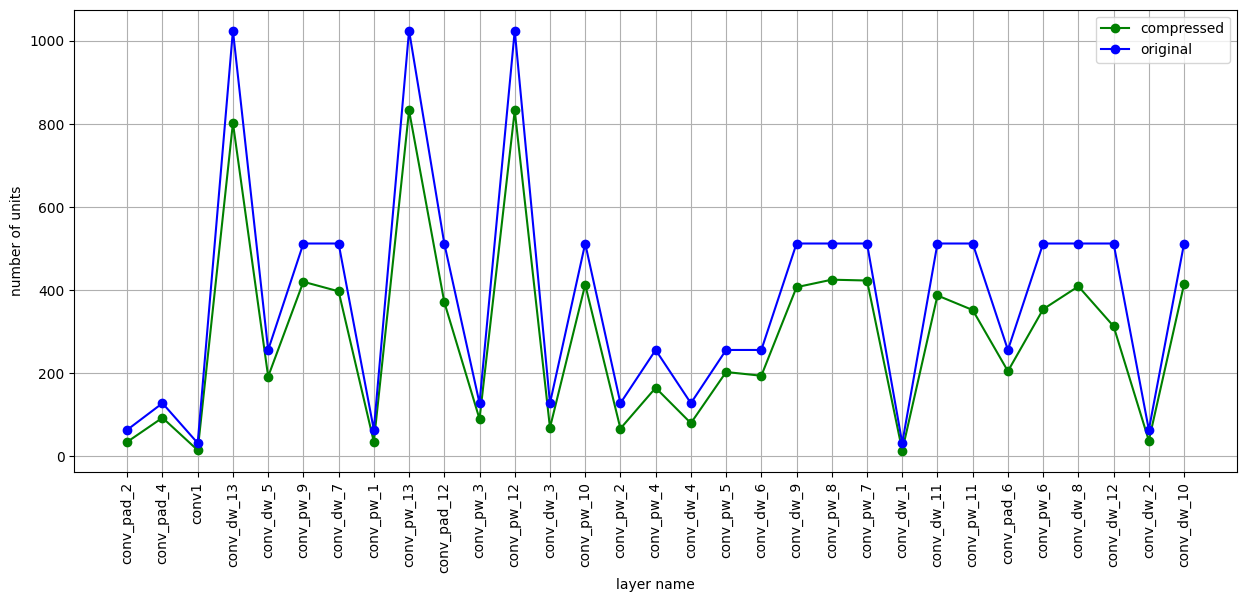

In [13]:
PFA.show(pfa_kl_recipe, vis_type=PFA.VisType.CHART)